# Project Description - Automatic Steel Defects classification and localization

**Introduction** <br>
This is a project of defects classification/localization for steel defects on the GC10-DET surface dataset using transfer learning. VGG16 is used for training the dataset. 

**Outline** <br>
This project will have the presentation outlined as follows,
1. Dataset visualization
2. Model training and validation
3. Model testing
4. Results evaluation
5. Model prediction

In [11]:
# Import necessary libraries

import re
from PIL import Image
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import random
import os
from matplotlib.patches import Rectangle
from matplotlib import pyplot
from lxml import etree
import csv
import xml.etree.ElementTree as ET
import imageio
from imgaug.augmentables.bbs import BoundingBox, BoundingBoxesOnImage
from imgaug import augmenters as iaa 
import imgaug as ia
ia.seed(1)
# Enable Matplotlib backend for displaying static images
%matplotlib inline

import subprocess

from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input as resnet50_preprocess_input

Las siguientes líneas sólo se deben ejecutar la primera vez. De esta forma se descomprimen y organizan los datos adecuadamente.

In [12]:
#!mkdir '/content/sample_data/Metal'
#!unzip -q '/content/drive/My Drive/Colab Notebooks/Computer Vision course/DL/images/Metallic database.zip' -d '/content/sample_data/Metal/images'
#!mv  -v '/content/sample_data/Metal/images/label' '/content/sample_data/Metal/label'

In [13]:
STORAGE_BUCKET = 'frank_mia'
DATA_PATH = 'Metallic Database'
LOCAL_PATH = '/tmp'
PROJECT_ID = 'carbide-canto-338415'


# Download dataset
subprocess.call([
  'gsutil', '-m', 'cp', '-r',
  # Storage path
  os.path.join('gs://', STORAGE_BUCKET, DATA_PATH),
  # Local path
  LOCAL_PATH
])
# Read all the images and count the number of image paths in the training subfolders
image_path = glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "images/*/*.jpg"))
image_path = [f.replace('\\','/') for f in image_path]
print(f'image_path {len(image_path)}',flush=True)

# Read all the annotation files and count the number of annotations in the training label folder

xmls_path = glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "label/*.xml"))
xmls_path = [f.replace('\\','/') for f in xmls_path]
print(len(xmls_path))

Copying gs://frank_mia/Metallic Database/images/Crease/img_01_3436789500_00004.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_01_425382900_00002.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_01_425501700_00022.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_01_429539000_00002.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_01_4402117100_00006.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_01_4402116900_00003.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_01_4402270500_00003.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_01_4402270500_00004.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_01_4402117200_00003.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_01_4403690400_00005.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/img_02_3436789500_00005.jpg...
Copying gs://frank_mia/Metallic Database/images/Crease/im

image_path 4468


4468


In [4]:
# Function that will extract column data for our CSV file as pandas DataFrame
def xml_to_csv(path):
    xml_list = []
    for xml_file in glob.glob(path + '/*.xml'):
        tree = ET.parse(xml_file)
        root = tree.getroot()
        for member in root.findall('object'):
            try:
                value = (root.find('filename').text,
                         int(root.find('size')[0].text),
                         int(root.find('size')[1].text),
                         member[0].text,
                         int(member[4][0].text),
                         int(member[4][1].text),
                         int(member[4][2].text),
                         int(member[4][3].text)
                         )
                xml_list.append(value)
            except:
                pass
    column_name = ['filename', 'width', 'height', 'class', 'xmin', 'ymin', 'xmax', 'ymax']
    xml_df = pd.DataFrame(xml_list, columns=column_name)
    return xml_df
   
# apply the function to convert all XML files in images/ folder into labels.csv
labels_df = xml_to_csv('/tmp/Metallic Database/label/')
labels_df.to_csv(('labels.csv'), index=None)

In [5]:
#Function that returns images filename folder name.
def folderfinder(filename, path):
    for root, dirs, files in os.walk(path):
        if filename in files:
            return os.path.join(root)
        
# function to convert BoundingBoxesOnImage object into DataFrame
def bbs_obj_to_df(bbs_object):
#     convert BoundingBoxesOnImage object into array
    bbs_array = bbs_object.to_xyxy_array()
#     convert array into a DataFrame ['xmin', 'ymin', 'xmax', 'ymax'] columns
    df_bbs = pd.DataFrame(bbs_array, columns=['xmin', 'ymin', 'xmax', 'ymax'])
    return df_bbs

#Define the augmentor...
aug = iaa.SomeOf(2, [    
    iaa.Affine(scale=(0.5, 1.5)),
    iaa.Affine(translate_percent={"x":(-0.3, 0.3),"y":(-0.3, 0.3)}),
    iaa.Fliplr(1),
    iaa.Multiply((0.5, 1.5)),
    iaa.GaussianBlur(sigma=(1.0, 3.0)),
    iaa.AdditiveGaussianNoise(scale=(0.03*255, 0.05*255))
])

In [6]:
#Augment images to upsample our dataset. Corresponding object bounding boxes should be augmented accordingly...

def image_aug(df, images_path, image_prefix, augmentor):
    # create data frame which we're going to populate with augmented image info
    aug_bbs_xy = pd.DataFrame(columns=
                              ['filename','width','height','class', 'xmin', 'ymin', 'xmax', 'ymax']
                             )
    grouped = df.groupby('filename')
    
    for filename in df['filename'].unique():
    #   get separate data frame grouped by file name
        group_df = grouped.get_group(filename)
        group_df = group_df.reset_index()
        group_df = group_df.drop(['index'], axis=1)   
        
        folder=folderfinder(filename,images_path)
    #   read the image
        image = imageio.imread(folder+'/'+filename)
    #   get bounding boxes coordinates and write into array        
        bb_array = group_df.drop(['filename', 'width', 'height', 'class'], axis=1).values
    #   pass the array of bounding boxes coordinates to the imgaug library
        bbs = BoundingBoxesOnImage.from_xyxy_array(bb_array, shape=image.shape)
    #   apply augmentation on image and on the bounding boxes
        image_aug, bbs_aug = augmentor(image=image, bounding_boxes=bbs)
    #   disregard bounding boxes which have fallen out of image pane    
        bbs_aug = bbs_aug.remove_out_of_image()
    #   clip bounding boxes which are partially outside of image pane
        bbs_aug = bbs_aug.clip_out_of_image()
        
    #   don't perform any actions with the image if there are no bounding boxes left in it    
        if re.findall('Image...', str(bbs_aug)) == ['Image([]']:
            pass
        
    #   otherwise continue
        else:
        #   write augmented image to a file
            imageio.imwrite(folder+'/'+image_prefix+filename, image_aug)  
            
        #   create a data frame with augmented values of image width and height
            info_df = group_df.drop(['xmin', 'ymin', 'xmax', 'ymax'], axis=1)    
            for index, _ in info_df.iterrows():
                info_df.at[index, 'width'] = image_aug.shape[1]
                info_df.at[index, 'height'] = image_aug.shape[0]
        #   rename filenames by adding the predifined prefix
            info_df['filename'] = info_df['filename'].apply(lambda x: image_prefix+x)
        #   create a data frame with augmented bounding boxes coordinates using the function we created earlier
            bbs_df = bbs_obj_to_df(bbs_aug)
        #   concat all new augmented info into new data frame
            aug_df = pd.concat([info_df, bbs_df], axis=1)
        #   append rows to aug_bbs_xy data frame
            aug_bbs_xy = pd.concat([aug_bbs_xy, aug_df])            
    
    # return dataframe with updated images and bounding boxes annotations 
    aug_bbs_xy = aug_bbs_xy.reset_index()
    aug_bbs_xy = aug_bbs_xy.drop(['index'], axis=1)
    return aug_bbs_xy

In [7]:
#Apply function defined on top to get augmented images dataset.

Aug_df=image_aug(labels_df, os.path.join(LOCAL_PATH, DATA_PATH,"images/") , 'AUGMENTED', aug)
Aug_df.to_csv(('Aug_labels.csv'), index=None)
Aug_df=Aug_df.dropna(axis=0)


In [8]:
Aug_df.xmin=Aug_df.xmin.astype(int)
Aug_df.ymin=Aug_df.ymin.astype(int)
Aug_df.xmax=Aug_df.xmax.astype(int)
Aug_df.ymax=Aug_df.ymax.astype(int)

In [9]:
Aug_df.head()

,filename,width,height,class,xmin,ymin,xmax,ymax
0,AUGMENTEDimg_03_425501800_01202.jpg,2048,1000,7_yiwu,420,30,494,98
1,AUGMENTEDimg_03_425501800_01202.jpg,2048,1000,7_yiwu,533,162,608,219
2,AUGMENTEDimg_02_3436813700_00307.jpg,2048,1000,4_shuiban,499,9,862,775
3,AUGMENTEDimg_02_SIS001491_00257.jpg,2048,1000,6_siban,0,0,60,469
4,AUGMENTEDimg_07_4404613900_01090.jpg,2048,1000,2_hanfeng,0,682,2048,793


In [10]:
#Convert CSV to XML files.

for i in range(0,len(Aug_df)):
    height = Aug_df['height'].iloc[i]
    width = Aug_df['width'].iloc[i]
    depth=1

    annotation = ET.Element('annotation')
    ET.SubElement(annotation, 'filename').text = str(Aug_df['filename'].iloc[i])
    size = ET.SubElement(annotation, 'size')
    ET.SubElement(size, 'width').text = str(width)
    ET.SubElement(size, 'height').text = str(height)
    ET.SubElement(size, 'depth').text = str(depth)
    ob = ET.SubElement(annotation, 'object')
    ET.SubElement(ob, 'name').text = str(Aug_df['class'].iloc[i])
    ET.SubElement(ob, 'pose').text = 'Unspecified'
    ET.SubElement(ob, 'truncated').text = '0'
    ET.SubElement(ob, 'difficult').text = '0'
    bbox = ET.SubElement(ob, 'bndbox')
    ET.SubElement(bbox, 'xmin').text = str(Aug_df['xmin'].iloc[i])
    ET.SubElement(bbox, 'ymin').text = str(Aug_df['ymin'].iloc[i])
    ET.SubElement(bbox, 'xmax').text = str(Aug_df['xmax'].iloc[i])
    ET.SubElement(bbox, 'ymax').text = str(Aug_df['ymax'].iloc[i])
    
    Aug_df['filename'].iloc[i]=Aug_df['filename'].iloc[i].replace('.jpg','')

    fileName = str(Aug_df['filename'].iloc[i])
    tree = ET.ElementTree(annotation)
    tree.write('/tmp/Metallic Database/label/'+fileName+'.xml')

/opt/conda/lib/python3.7/site-packages/pandas/core/indexing.py:1732: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_block(indexer, value, name)


In [11]:
xmls_path=glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "label/*.xml"))
image_path=glob.glob(os.path.join(LOCAL_PATH, DATA_PATH, "images/*/*.jpg"))
print(len(xmls_path))
print(len(image_path))

4468
4468


In [14]:
# Sort the annotation and image files in ascending order

xmls_path.sort(key = lambda x:x.split("/")[-1].split(".xml")[0])
image_path.sort(key = lambda x:x.split("/")[-1].split(".jpg")[0])

In [15]:
# Extract the annotation filename without file extension
xmls_train = [path.split("/")[-1].split(".")[0] for path in xmls_path]
xmls_train[:5]

['AUGMENTEDimg_01_3402617700_00001',
 'AUGMENTEDimg_01_3402617700_01009',
 'AUGMENTEDimg_01_3436789500_00004',
 'AUGMENTEDimg_01_3436814600_00259',
 'AUGMENTEDimg_01_3436815300_00473']

In [16]:
# Retrieve the image filename to match the annotation file counts
# Ensure unique counts of training images with the annotations

imgs_train = [img for img in image_path if (img.split("/")[-1].split)(".jpg")[0] in xmls_train]
imgs_train[0:5]

['/tmp/Metallic Database/images/Crescent gap/AUGMENTEDimg_01_3402617700_00001.jpg',
 '/tmp/Metallic Database/images/Crescent gap/AUGMENTEDimg_01_3402617700_01009.jpg',
 '/tmp/Metallic Database/images/Crease/AUGMENTEDimg_01_3436789500_00004.jpg',
 '/tmp/Metallic Database/images/Silk spot/AUGMENTEDimg_01_3436814600_00259.jpg',
 '/tmp/Metallic Database/images/Silk spot/AUGMENTEDimg_01_3436815300_00473.jpg']

In [17]:
len(imgs_train),len(xmls_train)

(4468, 4468)

In [18]:
# Extract label names as DataFrame column

labels = [label.split("/")[-2] for label in imgs_train]
labels[:5]

['Crescent gap', 'Crescent gap', 'Crease', 'Silk spot', 'Silk spot']

In [19]:
labels = pd.DataFrame(labels, columns = ["Defect Type"])
labels

,Defect Type
0,Crescent gap
1,Crescent gap
2,Crease
3,Silk spot
4,Silk spot
...,...
4463,Silk spot
4464,Silk spot
4465,Silk spot
4466,Silk spot


In [20]:
# One-hot encoding for multiple classes
from sklearn.preprocessing import LabelBinarizer

# Obtain training labels without duplication
Class = labels["Defect Type"].unique()
# Store data values in key:value pairs with Python dictionaries
Class_dict = dict(zip(Class, range(1,len(Class) + 1)))
labels["Class"] = labels["Defect Type"].apply(lambda x: Class_dict[x])


lb = LabelBinarizer()
# Fit label binarizer
lb.fit(list(Class_dict.values()))
# Convert multi-class labels to binary labels (belong or does not belong to the class)
transformed_labels = lb.transform(labels["Class"])
y_bin_labels = []  

for i in range(transformed_labels.shape[1]):
    y_bin_labels.append("Class" + str(i))
    labels["Class" + str(i + 1)] = transformed_labels[:, i]   

In [21]:
Class_dict

{'Crescent gap': 1,
 'Crease': 2,
 'Silk spot': 3,
 'Water spot': 4,
 'Welding line': 5,
 'Inclusion': 6,
 'Oil spot': 7,
 'Waist folding': 8,
 'Rolled pit': 9,
 'Punching hole': 10}

In [22]:
labels.drop("Class", axis = 1, inplace = True)
labels.drop("Defect Type", axis = 1, inplace = True)
labels.head()

,Class1,Class2,Class3,Class4,Class5,Class6,Class7,Class8,Class9,Class10
0,1,0,0,0,0,0,0,0,0,0
1,1,0,0,0,0,0,0,0,0,0
2,0,1,0,0,0,0,0,0,0,0
3,0,0,1,0,0,0,0,0,0,0
4,0,0,1,0,0,0,0,0,0,0


In [23]:
# Function to parse and extract information from annotation files

def to_labels(path):
    # Read the annotation file
    xml = open("{}".format(path)).read()                         
    sel = etree.HTML(xml)
    # Obtain the image width
    width = int(sel.xpath("//size/width/text()")[0])
    # Obtain the image height
    height = int(sel.xpath("//size/height/text()")[0])  
    # Extract the bounding box coordinates
    xmin = int(sel.xpath("//bndbox/xmin/text()")[0])
    xmax = int(sel.xpath("//bndbox/xmax/text()")[0])
    ymin = int(sel.xpath("//bndbox/ymin/text()")[0])
    ymax = int(sel.xpath("//bndbox/ymax/text()")[0])
    # Return the relative coordinates
    return [xmin/width, ymin/height, xmax/width, ymax/height]

In [24]:
# Display the relative bounding box coordinates
coors = [to_labels(path) for path in xmls_path]
coors[:5]

[[0.7998046875, 0.763, 0.88818359375, 0.924],
 [0.58740234375, 0.174, 0.6904296875, 0.734],
 [0.65283203125, 0.179, 0.7666015625, 0.244],
 [0.50634765625, 0.017, 0.6357421875, 0.993],
 [0.2568359375, 0.017, 0.6025390625, 0.978]]

In [25]:
# Set four coordinate points as outputs

xmin, ymin, xmax, ymax = list(zip(*coors))

# Convert to Numpy array
xmin = np.array(xmin)
ymin = np.array(ymin)
xmax = np.array(xmax)
ymax = np.array(ymax)
label = np.array(labels.values)

In [26]:
# Creates a Dataset whose elements are slices of the given tensors
# Slicing a 1D tensor produces scalar tensor elements

labels_dataset = tf.data.Dataset.from_tensor_slices((xmin, ymin, xmax, ymax, label))
labels_dataset

2022-01-26 08:59:17.363007: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 08:59:17.492582: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 08:59:17.493438: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-01-26 08:59:17.496764: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags

<TensorSliceDataset shapes: ((), (), (), (), (10,)), types: (tf.float64, tf.float64, tf.float64, tf.float64, tf.int64)>

In [27]:
# Load the image from image path

def load_image(path):
    image = tf.io.read_file(path)                           
    image = tf.image.decode_jpeg(image,3)               
    image = tf.image.resize(image,[224,224])               
    image = tf.cast(image,tf.float32)  
    image = image / 255
    return image

In [28]:
# Build the dataset

dataset = tf.data.Dataset.from_tensor_slices(imgs_train)
dataset = dataset.map(load_image)

dataset_label = tf.data.Dataset.zip((dataset, labels_dataset))
dataset_label

<ZipDataset shapes: ((224, 224, 3), ((), (), (), (), (10,))), types: (tf.float32, (tf.float64, tf.float64, tf.float64, tf.float64, tf.int64))>

In [29]:
# Shuffle the images and extract the images by the defined batch size

batch_size = 32
dataset_label = dataset_label.repeat().shuffle(500).batch(batch_size)
#dataset_label = dataset_label.shuffle(500).batch(batch_size)

# Creates a Dataset that prefetches elements from this dataset
# Most dataset input pipelines should end with a call to prefetch
# This allows later elements to be prepared while the current element is being processed
# This often improves latency and throughput, at the cost of using additional memory to store prefetched elements
AUTOTUNE = tf.data.experimental.AUTOTUNE

dataset_label = dataset_label.cache().prefetch(buffer_size=AUTOTUNE)

In [30]:
# Split the dataset into 80% for training and 20% for testing

train_count = int(len(imgs_train) * 0.8)
test_count = int(len(imgs_train) * 0.2)
train_count, test_count

(3574, 893)

In [31]:
train_dataset = dataset_label.skip(test_count)
test_dataset = dataset_label.take(test_count)

In [32]:
class_dict = {v:k for k,v in Class_dict.items()}
class_dict

{1: 'Crescent gap',
 2: 'Crease',
 3: 'Silk spot',
 4: 'Water spot',
 5: 'Welding line',
 6: 'Inclusion',
 7: 'Oil spot',
 8: 'Waist folding',
 9: 'Rolled pit',
 10: 'Punching hole'}

2022-01-26 09:00:58.728820: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


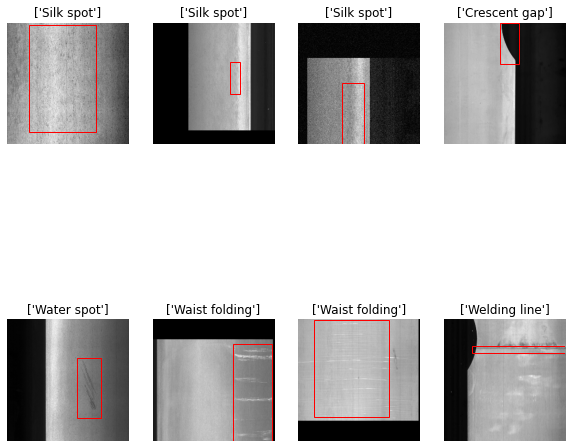

In [33]:
# Display a sample training image with its label
pyplot.figure(figsize=(10, 10))

for img,label in train_dataset.take(1):
  for i in range(8):

    ax = pyplot.subplot(2, 4, i + 1)    
    plt.imshow(keras.preprocessing.image.array_to_img(img[i]))     
    out1, out2, out3, out4, out5 = label                         
    xmin, ymin, xmax, ymax = out1[i].numpy()*224, out2[i].numpy()*224, out3[i].numpy()*224, out4[i].numpy()*224
    rect = Rectangle((xmin,ymin),(xmax - xmin),(ymax - ymin), fill = False, color = "r")  
    ax = plt.gca()                      
    ax.axes.add_patch(rect)   
    pred_imglist = []
    pred_imglist.append(class_dict[np.argmax(out5[i])+1])
    plt.title(pred_imglist)
    pyplot.axis("off")

    #plt.show()

**i. VGG16**

In [34]:
# Import VGG16 model with pre-trained weights from ImageNet

base_vgg16 = tf.keras.applications.ResNet152V2(weights = "imagenet",
                                         include_top = False,
                                         input_shape = (224,224,3),
                                         pooling = 'avg')

In [35]:
# Train only  fully-connected layers
base_vgg16.trainable = False

In [36]:
# Define the base model with fully-connected layers
inputs = keras.Input(shape = (224,224,3))
x = base_vgg16(inputs)

x1 = keras.layers.Dense(1024, activation = "relu")(x)
x1 = keras.layers.Dense(512, activation = "relu")(x1)
out1 = keras.layers.Dense(1, name = "xmin")(x1)
out2 = keras.layers.Dense(1, name = "ymin")(x1)
out3 = keras.layers.Dense(1, name = "xmax")(x1)
out4 = keras.layers.Dense(1, name = "ymax")(x1)

x2 = keras.layers.Dense(1024,activation = "relu")(x)
x2 = keras.layers.Dense(512,activation = "relu")(x2)
out_class = keras.layers.Dense(10,activation = "softmax", name = "class")(x2)

out = [out1, out2, out3, out4, out_class]

vgg16 = keras.models.Model(inputs = inputs, outputs = out)
vgg16.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 resnet152v2 (Functional)       (None, 2048)         58331648    ['input_2[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 1024)         2098176     ['resnet152v2[0][0]']            
                                                                                                  
 dense_2 (Dense)                (None, 1024)         2098176     ['resnet152v2[0][0]']        

In [37]:
# Compile the model with optimizer and loss functions

vgg16.compile(keras.optimizers.Adam(0.0005),
              loss = {"xmin": "mse",
                      "ymin": "mse",
                      "xmax": "mse",
                      "ymax": "mse",
                      "class": "categorical_crossentropy"},
              metrics = ["mae","acc"])

In [38]:
# Reduce learning rate

#lr_reduce = keras.callbacks.ReduceLROnPlateau("val_loss", patience = 5, factor = 0.5, min_lr = 1e-6)

In [ ]:
# Start training the model
#callbacks = [lr_reduce]
history = vgg16.fit(train_dataset,
                    steps_per_epoch = train_count//batch_size,
                    batch_size=batch_size,
                    epochs = 20 ,
                    validation_data = test_dataset,
                    validation_steps = test_count//batch_size)

Epoch 1/20


2022-01-26 09:02:12.759150: I tensorflow/stream_executor/cuda/cuda_dnn.cc:366] Loaded cuDNN version 8200


111/111 [==============================] - 141s 630ms/step - loss: 1.4202 - xmin_loss: 0.0750 - ymin_loss: 0.0626 - xmax_loss: 0.1338 - ymax_loss: 0.0913 - class_loss: 1.0575 - xmin_mae: 0.2146 - xmin_acc: 0.0262 - ymin_mae: 0.1923 - ymin_acc: 0.0363 - xmax_mae: 0.2656 - xmax_acc: 0.0746 - ymax_mae: 0.2349 - ymax_acc: 0.0859 - class_mae: 0.0955 - class_acc: 0.6410 - val_loss: 1.0659 - val_xmin_loss: 0.0556 - val_ymin_loss: 0.0503 - val_xmax_loss: 0.0600 - val_ymax_loss: 0.0490 - val_class_loss: 0.8510 - val_xmin_mae: 0.1884 - val_xmin_acc: 0.0706 - val_ymin_mae: 0.1821 - val_ymin_acc: 0.1273 - val_xmax_mae: 0.1953 - val_xmax_acc: 0.0926 - val_ymax_mae: 0.1745 - val_ymax_acc: 0.1308 - val_class_mae: 0.0844 - val_class_acc: 0.7083


2022-01-26 09:03:27.882974: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 2/20
111/111 [==============================] - 67s 608ms/step - loss: 0.8963 - xmin_loss: 0.0541 - ymin_loss: 0.0424 - xmax_loss: 0.0553 - ymax_loss: 0.0484 - class_loss: 0.6961 - xmin_mae: 0.1777 - xmin_acc: 0.0332 - ymin_mae: 0.1585 - ymin_acc: 0.0434 - xmax_mae: 0.1835 - xmax_acc: 0.0909 - ymax_mae: 0.1739 - ymax_acc: 0.0963 - class_mae: 0.0676 - class_acc: 0.7635 - val_loss: 1.0435 - val_xmin_loss: 0.0522 - val_ymin_loss: 0.0473 - val_xmax_loss: 0.0667 - val_ymax_loss: 0.0454 - val_class_loss: 0.8319 - val_xmin_mae: 0.1756 - val_xmin_acc: 0.0625 - val_ymin_mae: 0.1605 - val_ymin_acc: 0.1134 - val_xmax_mae: 0.1984 - val_xmax_acc: 0.0822 - val_ymax_mae: 0.1694 - val_ymax_acc: 0.1354 - val_class_mae: 0.0719 - val_class_acc: 0.7234


2022-01-26 09:04:35.310559: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 3/20
111/111 [==============================] - 67s 607ms/step - loss: 0.7732 - xmin_loss: 0.0457 - ymin_loss: 0.0393 - xmax_loss: 0.0484 - ymax_loss: 0.0426 - class_loss: 0.5973 - xmin_mae: 0.1609 - xmin_acc: 0.0504 - ymin_mae: 0.1526 - ymin_acc: 0.0591 - xmax_mae: 0.1700 - xmax_acc: 0.0892 - ymax_mae: 0.1603 - ymax_acc: 0.1073 - class_mae: 0.0609 - class_acc: 0.7889 - val_loss: 0.8416 - val_xmin_loss: 0.0412 - val_ymin_loss: 0.0361 - val_xmax_loss: 0.0478 - val_ymax_loss: 0.0437 - val_class_loss: 0.6728 - val_xmin_mae: 0.1545 - val_xmin_acc: 0.0625 - val_ymin_mae: 0.1511 - val_ymin_acc: 0.1192 - val_xmax_mae: 0.1713 - val_xmax_acc: 0.0775 - val_ymax_mae: 0.1570 - val_ymax_acc: 0.1308 - val_class_mae: 0.0648 - val_class_acc: 0.7662


2022-01-26 09:05:42.600757: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 4/20
111/111 [==============================] - 67s 606ms/step - loss: 0.6082 - xmin_loss: 0.0401 - ymin_loss: 0.0324 - xmax_loss: 0.0392 - ymax_loss: 0.0358 - class_loss: 0.4607 - xmin_mae: 0.1514 - xmin_acc: 0.0493 - ymin_mae: 0.1369 - ymin_acc: 0.0645 - xmax_mae: 0.1518 - xmax_acc: 0.0935 - ymax_mae: 0.1457 - ymax_acc: 0.1016 - class_mae: 0.0485 - class_acc: 0.8378 - val_loss: 0.5679 - val_xmin_loss: 0.0382 - val_ymin_loss: 0.0309 - val_xmax_loss: 0.0395 - val_ymax_loss: 0.0302 - val_class_loss: 0.4291 - val_xmin_mae: 0.1461 - val_xmin_acc: 0.0799 - val_ymin_mae: 0.1288 - val_ymin_acc: 0.1192 - val_xmax_mae: 0.1551 - val_xmax_acc: 0.0868 - val_ymax_mae: 0.1354 - val_ymax_acc: 0.1192 - val_class_mae: 0.0483 - val_class_acc: 0.8634


2022-01-26 09:06:49.762918: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 5/20
111/111 [==============================] - 67s 606ms/step - loss: 0.4897 - xmin_loss: 0.0343 - ymin_loss: 0.0269 - xmax_loss: 0.0341 - ymax_loss: 0.0323 - class_loss: 0.3621 - xmin_mae: 0.1370 - xmin_acc: 0.0422 - ymin_mae: 0.1246 - ymin_acc: 0.0563 - xmax_mae: 0.1392 - xmax_acc: 0.0856 - ymax_mae: 0.1386 - ymax_acc: 0.0977 - class_mae: 0.0404 - class_acc: 0.8722 - val_loss: 0.5174 - val_xmin_loss: 0.0261 - val_ymin_loss: 0.0227 - val_xmax_loss: 0.0270 - val_ymax_loss: 0.0231 - val_class_loss: 0.4185 - val_xmin_mae: 0.1172 - val_xmin_acc: 0.0752 - val_ymin_mae: 0.1125 - val_ymin_acc: 0.1308 - val_xmax_mae: 0.1235 - val_xmax_acc: 0.0810 - val_ymax_mae: 0.1159 - val_ymax_acc: 0.1285 - val_class_mae: 0.0454 - val_class_acc: 0.8565


2022-01-26 09:07:56.893274: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 6/20
111/111 [==============================] - 67s 606ms/step - loss: 0.3572 - xmin_loss: 0.0290 - ymin_loss: 0.0244 - xmax_loss: 0.0286 - ymax_loss: 0.0277 - class_loss: 0.2475 - xmin_mae: 0.1237 - xmin_acc: 0.0304 - ymin_mae: 0.1181 - ymin_acc: 0.0408 - xmax_mae: 0.1260 - xmax_acc: 0.0842 - ymax_mae: 0.1273 - ymax_acc: 0.0957 - class_mae: 0.0289 - class_acc: 0.9122 - val_loss: 0.3811 - val_xmin_loss: 0.0262 - val_ymin_loss: 0.0219 - val_xmax_loss: 0.0249 - val_ymax_loss: 0.0220 - val_class_loss: 0.2861 - val_xmin_mae: 0.1212 - val_xmin_acc: 0.0799 - val_ymin_mae: 0.1136 - val_ymin_acc: 0.1181 - val_xmax_mae: 0.1210 - val_xmax_acc: 0.0845 - val_ymax_mae: 0.1138 - val_ymax_acc: 0.1377 - val_class_mae: 0.0313 - val_class_acc: 0.8970


2022-01-26 09:09:03.999746: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 7/20
111/111 [==============================] - 67s 606ms/step - loss: 0.3372 - xmin_loss: 0.0256 - ymin_loss: 0.0218 - xmax_loss: 0.0250 - ymax_loss: 0.0239 - class_loss: 0.2409 - xmin_mae: 0.1177 - xmin_acc: 0.0352 - ymin_mae: 0.1110 - ymin_acc: 0.0419 - xmax_mae: 0.1179 - xmax_acc: 0.0943 - ymax_mae: 0.1172 - ymax_acc: 0.0957 - class_mae: 0.0275 - class_acc: 0.9186 - val_loss: 0.4724 - val_xmin_loss: 0.0235 - val_ymin_loss: 0.0248 - val_xmax_loss: 0.0342 - val_ymax_loss: 0.0240 - val_class_loss: 0.3659 - val_xmin_mae: 0.1108 - val_xmin_acc: 0.0683 - val_ymin_mae: 0.1127 - val_ymin_acc: 0.1227 - val_xmax_mae: 0.1369 - val_xmax_acc: 0.0833 - val_ymax_mae: 0.1130 - val_ymax_acc: 0.1389 - val_class_mae: 0.0332 - val_class_acc: 0.8843


2022-01-26 09:10:11.127598: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 8/20
111/111 [==============================] - 67s 605ms/step - loss: 0.3035 - xmin_loss: 0.0232 - ymin_loss: 0.0220 - xmax_loss: 0.0252 - ymax_loss: 0.0231 - class_loss: 0.2101 - xmin_mae: 0.1111 - xmin_acc: 0.0524 - ymin_mae: 0.1107 - ymin_acc: 0.0605 - xmax_mae: 0.1169 - xmax_acc: 0.0923 - ymax_mae: 0.1145 - ymax_acc: 0.1101 - class_mae: 0.0250 - class_acc: 0.9288 - val_loss: 0.3734 - val_xmin_loss: 0.0264 - val_ymin_loss: 0.0236 - val_xmax_loss: 0.0271 - val_ymax_loss: 0.0244 - val_class_loss: 0.2719 - val_xmin_mae: 0.1256 - val_xmin_acc: 0.0787 - val_ymin_mae: 0.1188 - val_ymin_acc: 0.1273 - val_xmax_mae: 0.1211 - val_xmax_acc: 0.0868 - val_ymax_mae: 0.1147 - val_ymax_acc: 0.1296 - val_class_mae: 0.0302 - val_class_acc: 0.8947


2022-01-26 09:11:18.185386: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 9/20
111/111 [==============================] - 67s 606ms/step - loss: 0.2394 - xmin_loss: 0.0208 - ymin_loss: 0.0175 - xmax_loss: 0.0193 - ymax_loss: 0.0208 - class_loss: 0.1610 - xmin_mae: 0.1051 - xmin_acc: 0.0504 - ymin_mae: 0.0988 - ymin_acc: 0.0659 - xmax_mae: 0.1038 - xmax_acc: 0.0909 - ymax_mae: 0.1083 - ymax_acc: 0.1044 - class_mae: 0.0192 - class_acc: 0.9474 - val_loss: 0.2055 - val_xmin_loss: 0.0184 - val_ymin_loss: 0.0169 - val_xmax_loss: 0.0186 - val_ymax_loss: 0.0191 - val_class_loss: 0.1326 - val_xmin_mae: 0.1004 - val_xmin_acc: 0.0613 - val_ymin_mae: 0.0936 - val_ymin_acc: 0.1215 - val_xmax_mae: 0.1044 - val_xmax_acc: 0.0914 - val_ymax_mae: 0.1088 - val_ymax_acc: 0.1343 - val_class_mae: 0.0188 - val_class_acc: 0.9630


2022-01-26 09:12:25.323708: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 10/20
111/111 [==============================] - 67s 606ms/step - loss: 0.1677 - xmin_loss: 0.0178 - ymin_loss: 0.0155 - xmax_loss: 0.0181 - ymax_loss: 0.0188 - class_loss: 0.0975 - xmin_mae: 0.0978 - xmin_acc: 0.0403 - ymin_mae: 0.0941 - ymin_acc: 0.0510 - xmax_mae: 0.1006 - xmax_acc: 0.0943 - ymax_mae: 0.1040 - ymax_acc: 0.0971 - class_mae: 0.0129 - class_acc: 0.9733 - val_loss: 0.1417 - val_xmin_loss: 0.0158 - val_ymin_loss: 0.0154 - val_xmax_loss: 0.0169 - val_ymax_loss: 0.0185 - val_class_loss: 0.0752 - val_xmin_mae: 0.0929 - val_xmin_acc: 0.0775 - val_ymin_mae: 0.0899 - val_ymin_acc: 0.1296 - val_xmax_mae: 0.1004 - val_xmax_acc: 0.0903 - val_ymax_mae: 0.1081 - val_ymax_acc: 0.1343 - val_class_mae: 0.0112 - val_class_acc: 0.9850


2022-01-26 09:13:32.461236: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 11/20
111/111 [==============================] - 67s 606ms/step - loss: 0.1329 - xmin_loss: 0.0143 - ymin_loss: 0.0141 - xmax_loss: 0.0142 - ymax_loss: 0.0159 - class_loss: 0.0743 - xmin_mae: 0.0878 - xmin_acc: 0.0265 - ymin_mae: 0.0893 - ymin_acc: 0.0419 - xmax_mae: 0.0880 - xmax_acc: 0.0892 - ymax_mae: 0.0955 - ymax_acc: 0.0926 - class_mae: 0.0097 - class_acc: 0.9747 - val_loss: 0.1224 - val_xmin_loss: 0.0144 - val_ymin_loss: 0.0120 - val_xmax_loss: 0.0144 - val_ymax_loss: 0.0148 - val_class_loss: 0.0667 - val_xmin_mae: 0.0876 - val_xmin_acc: 0.0706 - val_ymin_mae: 0.0825 - val_ymin_acc: 0.1215 - val_xmax_mae: 0.0868 - val_xmax_acc: 0.0856 - val_ymax_mae: 0.0917 - val_ymax_acc: 0.1308 - val_class_mae: 0.0099 - val_class_acc: 0.9803


2022-01-26 09:14:39.564581: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 12/20
111/111 [==============================] - 67s 606ms/step - loss: 0.1191 - xmin_loss: 0.0127 - ymin_loss: 0.0132 - xmax_loss: 0.0136 - ymax_loss: 0.0153 - class_loss: 0.0642 - xmin_mae: 0.0826 - xmin_acc: 0.0419 - ymin_mae: 0.0849 - ymin_acc: 0.0428 - xmax_mae: 0.0861 - xmax_acc: 0.0932 - ymax_mae: 0.0930 - ymax_acc: 0.0991 - class_mae: 0.0088 - class_acc: 0.9797 - val_loss: 0.1712 - val_xmin_loss: 0.0147 - val_ymin_loss: 0.0135 - val_xmax_loss: 0.0173 - val_ymax_loss: 0.0157 - val_class_loss: 0.1101 - val_xmin_mae: 0.0902 - val_xmin_acc: 0.0799 - val_ymin_mae: 0.0878 - val_ymin_acc: 0.1204 - val_xmax_mae: 0.0954 - val_xmax_acc: 0.0868 - val_ymax_mae: 0.0918 - val_ymax_acc: 0.1400 - val_class_mae: 0.0133 - val_class_acc: 0.9676


2022-01-26 09:15:46.690517: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 13/20
111/111 [==============================] - 67s 606ms/step - loss: 0.0926 - xmin_loss: 0.0120 - ymin_loss: 0.0111 - xmax_loss: 0.0127 - ymax_loss: 0.0135 - class_loss: 0.0433 - xmin_mae: 0.0806 - xmin_acc: 0.0521 - ymin_mae: 0.0785 - ymin_acc: 0.0639 - xmax_mae: 0.0834 - xmax_acc: 0.0974 - ymax_mae: 0.0879 - ymax_acc: 0.1092 - class_mae: 0.0065 - class_acc: 0.9916 - val_loss: 0.1003 - val_xmin_loss: 0.0179 - val_ymin_loss: 0.0127 - val_xmax_loss: 0.0150 - val_ymax_loss: 0.0138 - val_class_loss: 0.0409 - val_xmin_mae: 0.1101 - val_xmin_acc: 0.0810 - val_ymin_mae: 0.0850 - val_ymin_acc: 0.1181 - val_xmax_mae: 0.0893 - val_xmax_acc: 0.0799 - val_ymax_mae: 0.0877 - val_ymax_acc: 0.1354 - val_class_mae: 0.0063 - val_class_acc: 0.9873


2022-01-26 09:16:53.879150: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 14/20
111/111 [==============================] - 67s 606ms/step - loss: 0.0839 - xmin_loss: 0.0107 - ymin_loss: 0.0095 - xmax_loss: 0.0106 - ymax_loss: 0.0120 - class_loss: 0.0410 - xmin_mae: 0.0776 - xmin_acc: 0.0498 - ymin_mae: 0.0740 - ymin_acc: 0.0639 - xmax_mae: 0.0778 - xmax_acc: 0.0895 - ymax_mae: 0.0827 - ymax_acc: 0.1042 - class_mae: 0.0057 - class_acc: 0.9873 - val_loss: 0.0773 - val_xmin_loss: 0.0101 - val_ymin_loss: 0.0089 - val_xmax_loss: 0.0128 - val_ymax_loss: 0.0139 - val_class_loss: 0.0316 - val_xmin_mae: 0.0751 - val_xmin_acc: 0.0729 - val_ymin_mae: 0.0730 - val_ymin_acc: 0.1215 - val_xmax_mae: 0.0834 - val_xmax_acc: 0.0856 - val_ymax_mae: 0.0915 - val_ymax_acc: 0.1447 - val_class_mae: 0.0053 - val_class_acc: 0.9977


2022-01-26 09:18:01.041692: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 15/20
111/111 [==============================] - 69s 623ms/step - loss: 0.0989 - xmin_loss: 0.0087 - ymin_loss: 0.0083 - xmax_loss: 0.0094 - ymax_loss: 0.0107 - class_loss: 0.0618 - xmin_mae: 0.0698 - xmin_acc: 0.0386 - ymin_mae: 0.0688 - ymin_acc: 0.0535 - xmax_mae: 0.0715 - xmax_acc: 0.0884 - ymax_mae: 0.0790 - ymax_acc: 0.0968 - class_mae: 0.0077 - class_acc: 0.9797 - val_loss: 0.1563 - val_xmin_loss: 0.0071 - val_ymin_loss: 0.0078 - val_xmax_loss: 0.0081 - val_ymax_loss: 0.0089 - val_class_loss: 0.1244 - val_xmin_mae: 0.0643 - val_xmin_acc: 0.0660 - val_ymin_mae: 0.0680 - val_ymin_acc: 0.1238 - val_xmax_mae: 0.0679 - val_xmax_acc: 0.0799 - val_ymax_mae: 0.0691 - val_ymax_acc: 0.1366 - val_class_mae: 0.0133 - val_class_acc: 0.9606


2022-01-26 09:19:10.014402: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


Epoch 16/20
 41/111 [==========>...................] - ETA: 1:11 - loss: 0.0949 - xmin_loss: 0.0073 - ymin_loss: 0.0091 - xmax_loss: 0.0080 - ymax_loss: 0.0107 - class_loss: 0.0597 - xmin_mae: 0.0626 - xmin_acc: 0.0457 - ymin_mae: 0.0710 - ymin_acc: 0.0434 - xmax_mae: 0.0670 - xmax_acc: 0.1059 - ymax_mae: 0.0759 - ymax_acc: 0.1120 - class_mae: 0.0081 - class_acc: 0.9787

In [ ]:
# Visualize the results after training

def plot_history(history):                
    hist = pd.DataFrame(history.history)           
    hist["epoch"] = history.epoch
    
    plt.figure()                                     
    plt.xlabel("Epoch")
    plt.ylabel("Mean Squared Error (MSE)")               
    plt.plot(hist["epoch"], hist["loss"], label = "training Loss")
    plt.plot(hist["epoch"], hist["val_loss"], label = "validation Loss")                           
    plt.legend()
    
    plt.figure()                                      
    plt.xlabel("Epoch")
    plt.ylabel("Validation Mean Absolute Error (MAE)")               
    plt.plot(hist["epoch"], hist["val_xmin_mae"], label = "xmin_MAE")
    plt.plot(hist["epoch"], hist["val_ymin_mae"], label = "ymin_MAE")
    plt.plot(hist["epoch"], hist["val_xmax_mae"], label = "xmax_MAE")
    plt.plot(hist["epoch"], hist["val_ymax_mae"], label = "ymax_MAE")
    plt.legend()      
    
    plt.figure()                                      
    plt.xlabel("Epoch")
    plt.ylabel("Validation Accuracy for Class")               
    plt.plot(hist["epoch"],hist["val_class_acc"], label = "class_accuracy")
    
    plt.show()
    
plot_history(history)  

In [ ]:
results = vgg16.evaluate(test_dataset)

In [ ]:
print("MAE of xmin value in test set:{}".format(results[6]))
print("MAE of ymin value in test set:{}".format(results[8]))
print("MAE of xmax value in test set:{}".format(results[10]))
print("MAE of ymax value in test set:{}".format(results[12]))
print("Testing accuracy of predicted label:{}".format(results[15]))

In [ ]:
#vgg16.save("vgg16.h5")

In [ ]:
# generate random integer values
from random import seed
from random import randint
seed(1)

plt.figure(figsize = (20, 15))
for img, GT in test_dataset.take(1):
    out1, out2, out3, out4, out5 = vgg16.predict(img)
    out1_gt, out2_gt, out3_gt, out4_gt, out5_gt = GT                         

    for i in range(8):
        num=randint(0, batch_size)
        plt.subplot(4, 4, i + 1)            
        plt.imshow(keras.preprocessing.image.array_to_img(img[num]))    
        pred_imglist = []
        pred_imglist.append(class_dict[np.argmax(out5[num]) + 1])

        gt_list=[]
        gt_list.append(class_dict[np.argmax(out5_gt[num]) + 1])
        plt.title('{0}  {1}'.format(gt_list, pred_imglist))

        xmin, ymin, xmax, ymax = out1[num]*224, out2[num]*224, out3[num]*224, out4[num]*224
        rect = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "r") 

        xmin, ymin, xmax, ymax = out1_gt[num]*224, out2_gt[num]*224, out3_gt[num]*224, out4_gt[num]*224
        rect2 = Rectangle((xmin,ymin), (xmax - xmin), (ymax - ymin), fill = False, color = "b") 

        ax = plt.gca()                   
        ax.axes.add_patch(rect)
        ax.axes.add_patch(rect2)

In [ ]:
# Append all the true labels into a list

true_labels = []

for _, label in test_dataset:    
    out1, out2, out3, out4, out5 = label                              
    true_labels.append(class_dict[np.argmax(out5) + 1])

In [ ]:
#true_labels

In [ ]:

test_labels = []

for img, label in test_dataset:
    out1, out2, out3, out4, out5 = label
    label = vgg16.predict(img)
    test_labels.append(class_dict[np.argmax(out5) + 1])

In [ ]:
#test_labels

In [ ]:
target_names = ['Cresent gap', 'Crease', 'Silk spot', 'Water spot', 'Welding line', 
                'Inclusion', 'Oil spot', 'Waist folding', 'Rolled pit', 'Punching hole']

In [ ]:
from sklearn.metrics import confusion_matrix

confusion_matrix(true_labels, test_labels, labels = target_names)